In [1]:
import numpy as np
import os

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import astropy

import qp
%config Completer.use_jedi = False

In [2]:
ens = qp.read('qp_test_ensemble.hdf5')
ens_red = ens[np.arange(2)]

In [3]:
ens_voigt0 = qp.convert(ens_red, class_name='voigt', method='xy')

[array([ 1.0000000e+00,  1.1809375e-01, -7.5312500e-02, -5.9750000e-02,
       -2.4843750e-02, -1.1937500e-02,  1.0593750e-02,  1.2281250e-02,
        7.4687500e-03, -1.2812500e-02, -3.9375000e-03, -6.4375000e-03,
        9.1875000e-03, -1.4062500e-03, -8.7500000e-04, -1.4062500e-03,
       -1.4687500e-03, -5.6250000e-04,  0.0000000e+00,  0.0000000e+00]), array([ 1.0000000e+00,  5.4621875e-01,  1.9996875e-01, -4.6968750e-02,
        8.1281250e-02,  2.2906250e-02,  4.0000000e-02, -3.1031250e-02,
        1.5593750e-02, -9.6875000e-03,  6.3750000e-03,  1.5562500e-02,
       -1.4593750e-02, -5.4687500e-03,  1.4687500e-03, -7.5000000e-04,
        2.0937500e-03,  6.8750000e-04, -5.0000000e-04,  0.0000000e+00])]


In [4]:
ens_voigt0.objdata()

{'weights': array([[ 1.0000000e+00,  1.1809375e-01, -7.5312500e-02, -5.9750000e-02,
         -2.4843750e-02, -1.1937500e-02,  1.0593750e-02,  1.2281250e-02,
          7.4687500e-03, -1.2812500e-02, -3.9375000e-03, -6.4375000e-03,
          9.1875000e-03, -1.4062500e-03, -8.7500000e-04, -1.4062500e-03,
         -1.4687500e-03, -5.6250000e-04,  0.0000000e+00,  0.0000000e+00],
        [ 1.0000000e+00,  5.4621875e-01,  1.9996875e-01, -4.6968750e-02,
          8.1281250e-02,  2.2906250e-02,  4.0000000e-02, -3.1031250e-02,
          1.5593750e-02, -9.6875000e-03,  6.3750000e-03,  1.5562500e-02,
         -1.4593750e-02, -5.4687500e-03,  1.4687500e-03, -7.5000000e-04,
          2.0937500e-03,  6.8750000e-04, -5.0000000e-04,  0.0000000e+00]]),
 'stds': array([[0.0270068 , 0.01687075, 0.00673469, 0.00673469, 0.00166667,
         0.01180272, 0.00166667, 0.00166667, 0.00166667, 0.00673469,
         0.00673469, 0.00166667, 0.00166667, 0.00166667, 0.00166667,
         0.00673469, 0.00166667, 0.00166

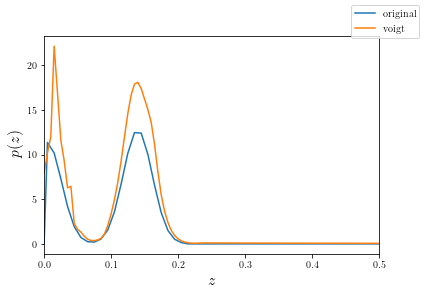

In [7]:
key = 1
axes_m = ens_red.plot(key, xlim=(0, 0.5), label="original")
_ = ens_voigt0.plot(key, axes=axes_m, label="voigt")
leg_m = axes_m.figure.legend()

In [8]:
# Convert to a gaussian mixture using 301 sample points and 3 components
ens_m3 = qp.convert(ens_red, 'mixmod', xvals=np.linspace(0, 3.0, 301), ncomps=3)

In [10]:
ens_voigt = qp.convert(ens_m3, 'voigt')

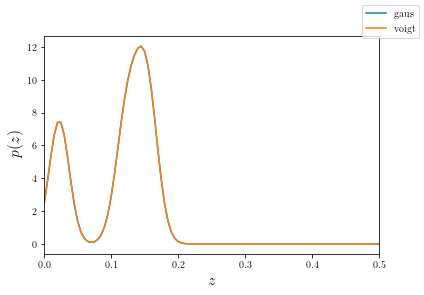

In [12]:
key = 1
axes_m = ens_m3.plot(key, xlim=(0, 0.5), label="gaus")
_ = ens_voigt.plot(key, axes=axes_m, label="voigt")
leg_m = axes_m.figure.legend()

In [2]:
from math import sqrt
from scipy import special
def voigt(x, x_mean, sigma, gamma):
    """
     Voigt profile
     V(x,sig,gam) = Re(w(z)), w(z) Faddeeva function
     z = (x+j*gamma)/(sigma*sqrt(2))

     :param float x: the x-axis values (redshift)
     :param float x_mean: Mean of the gaussian or Voigt
     :param float sigma: Sigma of the original Gaussian when gamma=0
     :param float gamma: Gamma parameter for the Lorentzian profile (Voigt)

     :return: The real values of the Voigt profile at points x
     """

    x = x - x_mean
    z = (x + 1j * gamma) / (sqrt(2.) * sigma)
    It = special.wofz(z).real
    return It


In [3]:
def get_N(longN):
    """
    Extract coefficients fro the 32bits integer,
    Extract Ncoef and Nbase from 32 bit integer
    return (longN >> 16), longN & 0xffff

    :param int longN: input 32 bits integer

    :return: Ncoef, Nbase both 16 bits integer
    """
    return (longN >> 16), (longN & (2 ** 16 - 1))


In [4]:
def reconstruct_pdf_g(index, vals, zfine, mu, Nmu, sigma, Nsigma, cut=1.e-5):
    """
    This function reconstruct the pdf from the indices and values and parameters used to create the dictionary with
    Gaussians only

    :param int index: List of indices in the dictionary for the selected bases
    :param float vals: values or coefficients corresponding to the listed indices
    :param float zfine: redshift values from the original pdf or used during the sparse representation
    :param float mu: [min_mu, max_mu] values used to create the dictionary
    :param int Nmu: Number of mu values used to create the dictionary
    :param float sigma: [min_sigma, mas_sigma] sigma values used to create the dictionary
    :param int Nsigma: Number of sigma values
    :param float cut: cut threshold when creating the dictionary

    :return: the pdf normalized so it sums to one
    """

    zmid = np.linspace(mu[0], mu[1], Nmu)
    sig = np.linspace(sigma[0], sigma[1], Nsigma)
    pdf = np.zeros(len(zfine))
    for k in range(len(index)):
        i = int(index[k] / Nsigma)
        j = index[k] % Nsigma
        pdft = 1. * np.exp(-((zfine - zmid[i]) ** 2) / (2. * sig[j] * sig[j]))
        pdft = np.where(pdft >= cut, pdft, 0.)
        pdft = pdft / np.linalg.norm(pdft)
        pdf += pdft * vals[k]
        #pdf = where(pdf >= cut, pdf, 0)
    pdf = np.where(np.greater(pdf, np.max(pdf) * 0.005), pdf, 0.)
    if np.sum(pdf) > 0: pdf = pdf / np.sum(pdf)
    return pdf


In [5]:
def reconstruct_pdf_v(index, vals, zfine, mu, Nmu, sigma, Nsigma, Nv, cut=1.e-5):
    """
    This function reconstruct the pdf from the indices and values and parameters used to create the dictionary with
    Gaussians and Voigt profiles

    :param int index: List of indices in the dictionary for the selected bases
    :param float vals: values or coefficients corresponding to the listed indices
    :param float zfine: redshift values from the original pdf or used during the sparse representation
    :param float mu: [min_mu, max_mu] values used to create the dictionary
    :param int Nmu: Number of mu values used to create the dictionary
    :param float sigma: [min_sigma, mas_sigma] sigma values used to create the dictionary
    :param int Nsigma: Number of sigma values
    :param int Nv: Number of Voigt profiles used to create dictionary
    :param float cut: cut threshold when creating the dictionary

    :return: the pdf normalized so it sums to one
    """

    zmid = np.linspace(mu[0], mu[1], Nmu)
    sig = np.linspace(sigma[0], sigma[1], Nsigma)
    gamma = np.linspace(0, 0.5, Nv)
    pdf = np.zeros(len(zfine))
    for kk in range(len(index)):
        i = int(index[kk] / (Nsigma * Nv))
        j = int((index[kk] % (Nsigma * Nv)) / Nv)
        k = int(index[kk] % (Nsigma * Nv)) % Nv
        #print(i,j,k)
        pdft = special.voigt_profile(zfine-zmid[i], sig[j], sig[j] * gamma[k])
        pdft = np.where(pdft >= cut, pdft, 0.)
        pdft = pdft / np.linalg.norm(pdft)
        pdf += pdft * vals[kk]
        #pdf = where(pdf >= cut, pdf, 0)
    pdf = np.where(np.greater(pdf, np.max(pdf) * 0.005), pdf, 0.)
    if np.sum(pdf) > 0: pdf = pdf / np.sum(pdf)
    return pdf

In [6]:
def reconstruct_pdf_int(long_index, header, cut=1.e-5):
    """
    This function reconstruct the pdf from the integer indices only and the parameters used to create the dictionary
    with Gaussians and Voigt profiles

    :param int long_index: List of indices including coefficients (32bits integer array)
    :param dict header: Dictionary of the fits file header with information used to create dictionary and sparse indices
    :param float cut: cut threshold when creating the dictionary

    :return: the pdf normalized so it sums to one
    """

    Ncoef = header['Ncoef']
    zfine = header['z']
    mu = header['mu']
    Nmu = header['Nmu']
    sigma = header['sig']
    Nsigma = header['Nsig']
    Nv = header['Nv']

    #JCT VALS = np.linspace(0, 1, Ncoef)
    #JCT dVals = VALS[1] - VALS[0]
    dVals = 1./(Ncoef-1)
    sp_ind = np.array(list(map(get_N, long_index)))
    spi = sp_ind[:, 0]
    Dind2 = sp_ind[:, 1]
    vals = spi * dVals
    ####
    vals[0]=1.
    ####
    rep_pdf = reconstruct_pdf_v(Dind2, vals, zfine, mu, Nmu, sigma, Nsigma, Nv)
    return rep_pdf


In [7]:
example_outfile='/home/cohen/lsst/codes/pipelines/photoz/SparsePz/example_out.fits'
with astropy.io.fits.open(example_outfile) as F:
    P = F[2].data.field('Sparse_indices')
    H = F[0].header
    head = {}
    head['Ntot'] = H['N_TOT']
    head['Nmu'] = H['N_MU']
    head['Nsig'] = H['N_SIGMA']
    head['Nv'] = H['N_VOIGT']
    head['Ncoef'] = H['N_COEF']
    head['Nspa'] = H['N_SPARSE']
    head['mu'] = [H['MU1'], H['MU2']]
    head['sig'] = [H['SIGMA1'], H['SIGMA2']]
    head['z'] = F[1].data.field('redshift')

P0 = np.load('/home/cohen/lsst/codes/pipelines/photoz/SparsePz/CFHTLens_sample.P.npy')
#P0.shape, P.shape, head

Text(0.5, 1.0, 'Galaxy example No: 40')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


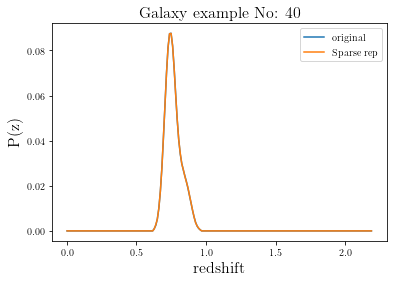

In [8]:
k=40
rep_pdf = reconstruct_pdf_int(P[k], head)

plt.plot(head['z'], P0[k] / sum(P0[k]), label='original')
plt.plot(head['z'], rep_pdf, label='Sparse rep')
plt.xlabel('redshift')
plt.ylabel('P(z)')
plt.legend(loc=0)
title = 'Galaxy example No: %d' % k
plt.title(title)


In [9]:
sp_pdf = qp.sparse_pdf.sparse_gen(P, head)

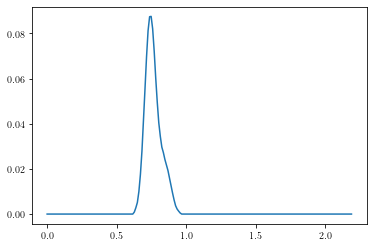

In [10]:
pdf = sp_pdf._pdf(head['z'], row=40)
plt.plot(head['z'], pdf, label='original')

In [16]:
sp_pdf.__class__

qp.sparse_pdf.sparse_gen

AttributeError: 'int' object has no attribute 'pdf'

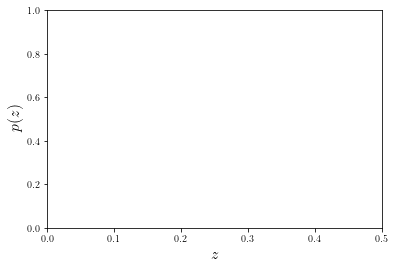

In [15]:
#this would work if sp_pdf was a sp ensemble, which it is not.... sp_pdf.plot(40, xlim=(0, 0.5))

In [12]:
z = ens_red.metadata()['xvals'][0]
dz = z[1] - z[0]
mu = [np.min(z), np.max(z)]
Nmu = 250 
max_sig = (np.max(z) - np.min(z)) / 12.
min_sig = dz / 6.
Nsig = int(np.ceil(2. * (max_sig - min_sig) / dz))
sig = [min_sig, max_sig]
#ens_sparse = qp.convert(ens_red, 'sparse', mu=mu, Nmu=Nmu, sig=sig, Nsig=Nsig)


NameError: name 'ens_red' is not defined

In [ ]:
ens_m3.metadata()

In [ ]:
ens_m3 = qp.convert(ens_red, 'sparse', xvals=np.linspace(0, 3.0, 301), ncomps=3)


In [ ]:
z=ens_red.metadata()['xvals'][0]
pdf=ens_red.pdf(ens_red.metadata()['xvals'][0])

In [ ]:
ens = qp.read('qp_test_ensemble.hdf5')
ens_red = ens[np.arange(100)]
print("Reduced ensemble has %i PDFs" % (ens_red.npdf))